# Simple model for $\nu$ arrival directions

Making use of the available effective area for muon tracks to get started.

In [39]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

## Read in the data

$A_{\rm{eff}}$ = $A_{\rm{eff}}(\omega, E)$ where $\omega$ is the position on the sky and $E$ is the true neutrino energy.

In [3]:
# Effective area
filename = 'data/3year-data-release/IC79-2010-TabulatedAeff.txt'
filelayout = ['Emin', 'Emax', 'cos(z)min', 'cos(z)max', 'Aeff']
output = pd.read_csv(filename, comment = '#',
                     delim_whitespace = True,
                     names = filelayout)

output_dict = output.to_dict()
Emin = list(output_dict['Emin'].values())
Emax = list(output_dict['Emax'].values())
coszmin = list(output_dict['cos(z)min'].values())
coszmax = list(output_dict['cos(z)max'].values())
Aeff = list(output_dict['Aeff'].values())

# find bin centres
Emin = np.sort(list(set(Emin)))
Emax = np.sort(list(set(Emax)))
Ec = (Emin + Emax)/2

coszmin = np.sort(list(set(coszmin)))
coszmax = np.sort(list(set(coszmax)))
coszc = (coszmin + coszmax)/2

/Users/fran/projects/bayes/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


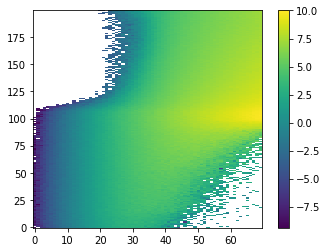

In [4]:
# sort into grid
# compare with plots in IceCube data release
A = np.transpose(np.reshape(Aeff, (70, 200)))
plt.imshow(np.log(A), origin = 'lower', aspect = 1/3)
plt.colorbar()
A = np.transpose(A)

## Interpolation/smoothing

In [5]:
from scipy import interpolate
from scipy import ndimage
sigma = [0.001, 5]
As = ndimage.filters.gaussian_filter(A, sigma, mode='constant')
effective_area = interpolate.RectBivariateSpline(Ec, coszc, A, s=0.0)
effective_area_smooth = interpolate.RectBivariateSpline(Ec, coszc, As, s=0.0)
norm = A.max()

Ignore energy dependence for now by just picking an energy to test with. So $A_{\rm{eff}} = A_{\rm{eff}}(\omega)$. Deal with the full problem later...

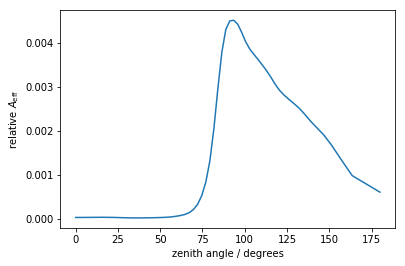

In [52]:
selected_E = 1e5 # GeV

m_smooth = []
cosz = np.linspace(-1, 1)
for c in cosz:
    m_smooth.append(effective_area_smooth(Etest, c)[0] / norm)
    
zenith = np.rad2deg(np.arccos(cosz)) 
fig, ax = plt.subplots()
ax.plot(zenith, m_smooth)
ax.set_xlabel('zenith angle / degrees')
ax.set_ylabel('relative $A_\mathrm{eff}$');

## Exposure factor

In the likelihood we have the expected number of detected neutrinos defined by $\bar{N} = \sum_k F_k \epsilon_k$, where $F_k$ is the flux of source $k$ and $\epsilon_k$ is the exposure factor for that source. In the UHECR case this was the convolution of the source vMF distribution with the effective area of the observatory. As we are selecting on the *true* neutrino arrival direction, in this case the integral is trivial.

$$
\epsilon_k = \int {\rm{d}}\omega \ p(\omega_i | \varpi_k) \epsilon(\omega) = T A_{\rm{ICX}} m(\omega)
$$


For the case of isotropic background, we have

$$
\epsilon_0 = \frac{1}{4\pi} \int \int {\rm{d}}t \ {\rm{d}}\omega \ \epsilon(\omega, t) = T A_{\rm{ICX}} \frac{M}{4\pi}
$$

where $M = \int {\rm{d}} \omega \ m(\omega)$.

In [49]:
def m(z):
    """
    Interpolation to return projection factor.
    
    NB: in the spherical coordinate system, southern zenith = np.pi - theta
    """
    cosz = np.cos(z)
    return effective_area_smooth(selected_E, cosz)[0] / norm

In [50]:
def m_integrand(theta, m):
    """
    Integrand for \int d(omega) mu(omega).

    Expressed as an integral in spherical coordinates for
    theta[0, pi]. For use with scipy.integrate.quad.

    m is an interpolation function representing the projection factor
    from IceCube data.

    NB: in the spherical coordinate system, southern zenith = np.pi - theta
    """

    zenith = np.pi - theta
    return 2 * np.pi * m(zenith) * np.sin(theta)


def bg_integrand(theta, effective_area):
    """
    Integrand for \int d theta effective_area(theta) sin(theta).

    Expressed in spherical coordinates for
    theta [0, pi] and phi [0, 2pi].
    """

    return 2*np.pi * effective_area(selected_E, np.cos(np.pi - theta)) * np.sin(theta)

In [51]:
# testing
from scipy import integrate

M, err = integrate.quad(m_integrand, 0, np.pi, args = (m))
print('M = ', integ, '+/-', err)
print('M / 4pi = ', integ / (4 * np.pi))

M =  0.022912642456839712 +/- 1.1704243559327997e-08
M / 4pi =  0.0018233301531516348


In [53]:
from fancy.plotting import AllSkyMap
from matplotlib.colors import Normalize
from astropy.coordinates import SkyCoord
from astropy import units as u

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

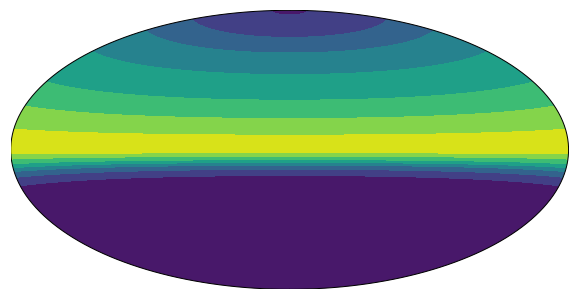

In [56]:
# plot on Skymap
# theta = np.pi/2 + dec
num_points = 50
declinations = np.linspace(-90, 90, num_points)
rightascensions = np.linspace(-180, 180, num_points)

for d in declinations:
    Aeff = np.array([
        (effective_area_smooth(selected_E, np.cos(np.pi/2 + np.deg2rad(d)))[0] / norm)[0] 
        for d in declinations])
Aeff = [Aeff for ra in rightascensions]

dec, ra = np.meshgrid(declinations, rightascensions)

fig, ax = plt.subplots()
fig.set_size_inches((10, 7))
skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0);
skymap.contourf(ra, dec, Aeff, latlon = True)

## Simple catalogue

In [65]:
# choose a set of sources and compute exposure factors
from fancy import Data
source_file = 'data/toy_cosmo_pop.h5'

data = Data()
data.add_source(source_file, 'cosmo_1000')

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).WARNING:Error plotting coords [199.72761472582988 87.78963555461581] with radius 3


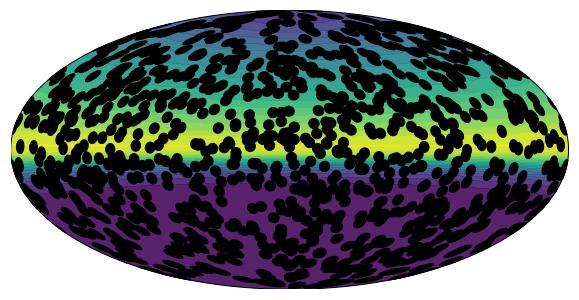

In [66]:
sra = data.source.coord.icrs.ra.rad
sdec = data.source.coord.icrs.dec.rad

fig, ax = plt.subplots()
fig.set_size_inches((10, 7))
skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0);
skymap.contourf(ra, dec, Aeff, 20, latlon = True, alpha = 0.9)
for sr, sd in zip(sra, sdec):
    skymap.tissot(np.rad2deg(sr), np.rad2deg(sd), 3, 30, color = 'k')

In [67]:
# choose observatory parameters
A_IC = norm # m^2
T = 1 # year
eps = []

# sources
for varpi in data.source.unit_vector:
    # get zenith of position
    zenith = np.pi - np.arccos( varpi[2] )
    mu = m(zenith)[0]
    eps.append(A_IC * T * mu)   
    
# background
eps.append(A_IC * T * (M / (4 * np.pi)))

In [68]:
# make interpolation grid to do selection
zenith_grid = np.linspace(0, np.pi)
m_grid = [m(z)[0] for z in zenith_grid]

## Stan simulation

Simulate with all sources in the population.

In [86]:
import stan_utility
sim = stan_utility.compile_model(filename = 'stan/test_nu_sim.stan', model_name = 'neutrino_sim')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL neutrino_sim_480c64f21af3ed2203b79676c721a954 NOW.


In [100]:
# Prepare inputs
Nsim = 1E5 # before exposure effects
alpha_T = eps[-1] * 4 * np.pi
FT = (Nsim * M) / alpha_T # m^-2 yr^-1

# Associated fraction
f = 0.5

D = data.source.distance # Mpc
Mpc_to_m = 3.086E22
L = ( (f * FT) / (sum([1 / (4 * np.pi * (d * Mpc_to_m)**2) for d in D])) )  # yr^-1
F0 = (1 - f) * FT # km^-2 yr^-1
kappa = 200

# Standard candle
print('F_T: ', FT)
print('F_s: ', f * FT)
print('L: ', L)
print('F_0: ', F0)

F_T:  4.484304932735426
F_s:  2.242152466367713
L:  1.1032165218221427e+51
F_0:  2.242152466367713


In [101]:
sim_input = {'Ns' : data.source.N,
             'varpi' : data.source.unit_vector,
             'D' : data.source.distance,
             'kappa' : kappa,
             'L' : L,
             'F0' : F0,
             'eps' : eps,
             'Ngrid' : len(m_grid),
             'm_grid' : m_grid,
             'zenith_grid' : zenith_grid}

simulation = sim.sampling(data = sim_input, iter =1, chains = 1, algorithm = "Fixed_param")

In [102]:
from fancy.interfaces.stan import Direction
event = simulation.extract(['event'])['event'][0]
event = Direction(event)
era = event.d.icrs.ra.rad
edec = event.d.icrs.dec.rad

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

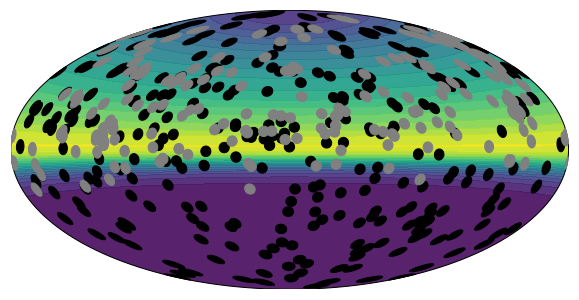

In [103]:
sra = data.source.coord.icrs.ra.rad
sdec = data.source.coord.icrs.dec.rad

fig, ax = plt.subplots()
fig.set_size_inches((10, 8))
skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0);
skymap.contourf(ra, dec, Aeff, 20, latlon = True, alpha = 0.9)
for sr, sd in zip(sra, sdec):
    skymap.tissot(np.rad2deg(sr), np.rad2deg(sd), 3, 30, color = 'k')
for er, ed in zip(era, edec):
    skymap.tissot(np.rad2deg(er), np.rad2deg(ed), 3, 30, color = 'grey')

## Stan fit

Fit only with sources within a certain $D_\rm{th}$. This represents a crude selection effect on source catalogue. This will need to be extended to incomplete catalogues.

In [106]:
#Dth = 2E4
Dth = 10000 # Mpc (z~1.4)
data.source.select_distance(Dth)
data.source.N
s = data.source.selection

eps0 = eps[-1]
eps = [eps[i] for i in s]
eps.append(eps0)

No fluxes to select on.


In [107]:
# prepare fit inputs
fit_input = {'N' : len(event.unit_vector), 
             'omega_det' : event.unit_vector, 
             'Ns' : data.source.N, 
             'varpi' : data.source.unit_vector,
             'D' : data.source.distance,
             'eps' : eps,
             'A_IC' : norm,
             'Ngrid' : len(m_grid),
             'm_grid' : m_grid,
             'zenith_grid' : zenith_grid}

In [115]:
model = stan_utility.compile_model(filename = 'stan/test_nu_model.stan', model_name = 'neutrino_model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL neutrino_model_6ce1104bfe99ea24bc073dd68529c66c NOW.


In [116]:
fit = model.sampling(data = fit_input, iter = 1000, chains = 4, seed = 19920715)

In [117]:
stan_utility.utils.check_treedepth(fit)
stan_utility.utils.check_div(fit)
stan_utility.utils.check_energy(fit)

0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 2000 iterations ended with a divergence (0.0%)
E-BFMI indicated no pathological behavior


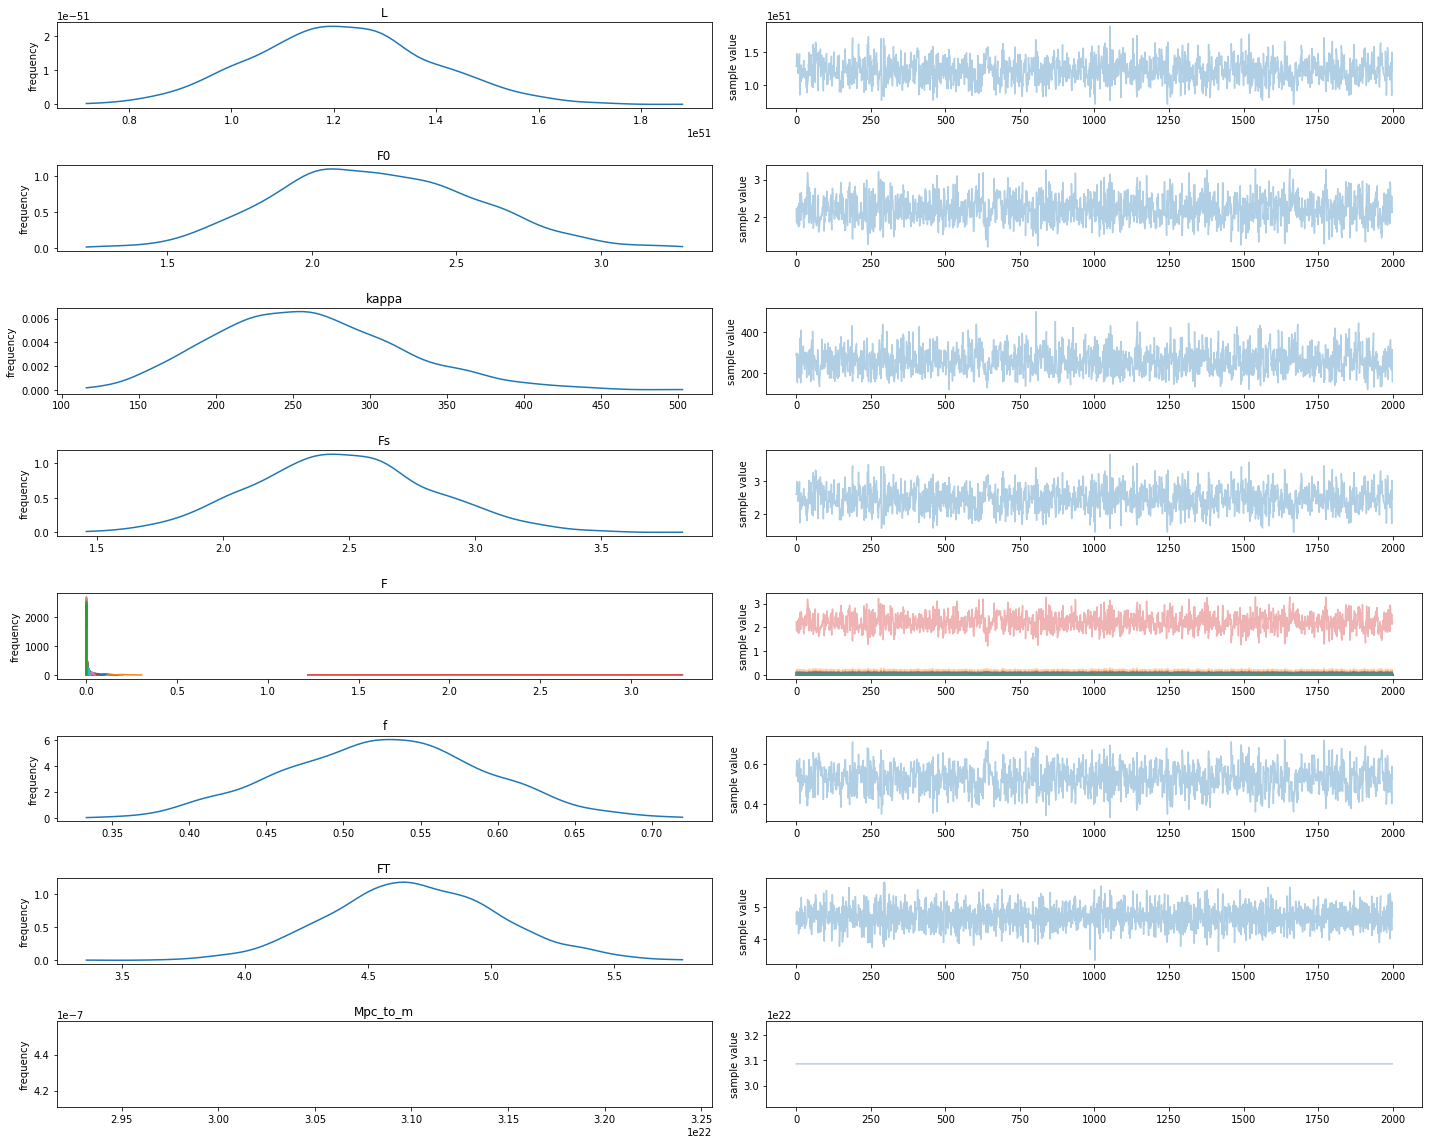

In [118]:
fig = fit.plot();
fig.set_size_inches(20, 16)
fig.tight_layout()

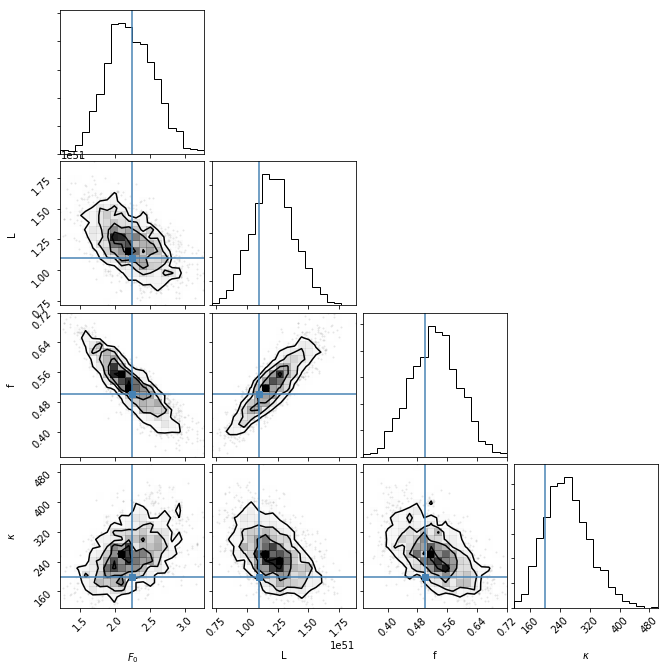

In [119]:
import corner
chain = fit.extract(permuted = True)
key_list = ['F0', 'L', 'f', 'kappa']
labels = [r'$F_0$', r'L', 'f', r'$\kappa$']
truths = [F0 , L , f, kappa]

corner.corner(np.nan_to_num(np.column_stack([chain[key] for key in key_list])),
              labels = labels, 
              truths = truths);